# 1. Introduction

This notebook demonstrates a method inspired by Singular Spectrum Analysis (SSA) to decompose a synthetic time series. Our steps include:

1. Generating a sample time series with a trend, two periodic signals, and random noise.  
2. Embedding the time series into a matrix called the trajectory matrix.  
3. Performing a linear algebra decomposition on that matrix.  
4. Reconstructing the time series from individual components and examining their correlations.  
5. Grouping the reconstructed components meaningfully (e.g., separating out a trend or periodic parts).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import pi
from cycler import cycler

# Set default plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)


# 2. Generating the Toy Time Series

Here, we create a time series by combining:
- A simple trend that depends on the index of each point.
- Two periodic signals with different frequencies.
- Random noise.

This forms a single signal we can later decompose.

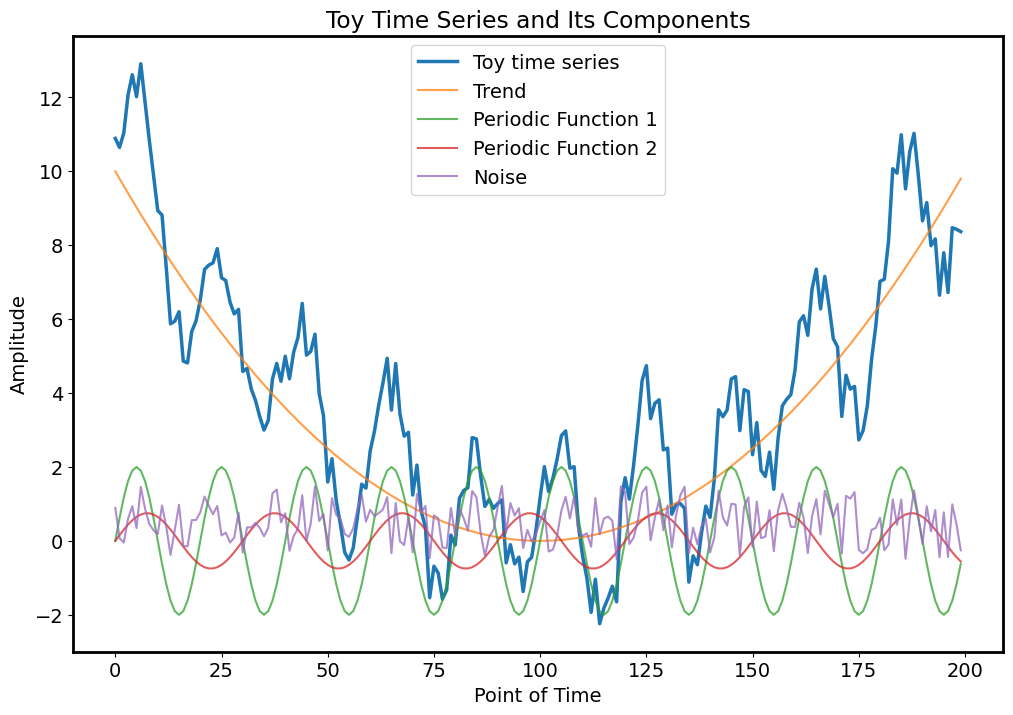

In [2]:
N = 200
t = np.arange(0, N)

trend = 0.001 * (t - 100) ** 2

p1 = 20
p2 = 30
f1 = 2 * np.sin(2 * pi * t / p1)
f2 = 0.75 * np.sin(2 * pi * t / p2)

np.random.seed(123)  # Consistent noise each time
noise = 2 * np.random.rand(N) - 0.5

signal = trend + f1 + f2 + noise

plt.plot(t, signal, lw=2.5, label='Toy time series')
plt.plot(t, trend, alpha=0.75, label='Trend')
plt.plot(t, f1, alpha=0.75, label='Periodic Function 1')
plt.plot(t, f2, alpha=0.75, label='Periodic Function 2')
plt.plot(t, noise, alpha=0.75, label='Noise')
plt.legend()
plt.xlabel('Point of Time')
plt.ylabel('Amplitude')
plt.title('Toy Time Series and Its Components')
plt.show()


# 3. Constructing the Trajectory Matrix

We choose a window size that defines how many points will appear in each column. By sliding this window across the time series, we capture overlapping segments. Each segment forms a column, and all columns together create the trajectory matrix.

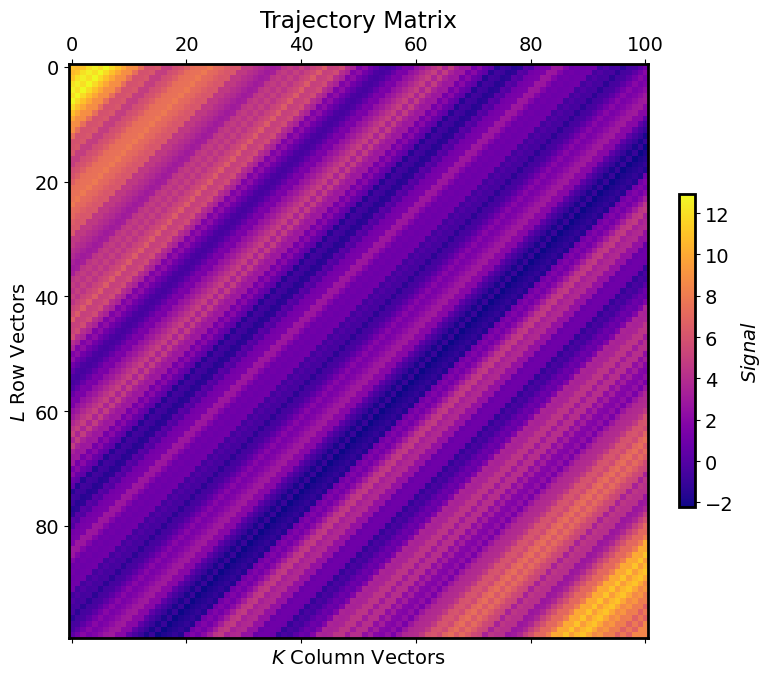

In [4]:
L = int(N / 2)
K = N - L + 1

X = np.column_stack([signal[i:i+L] for i in range(K)])

ax = plt.matshow(X)
plt.xlabel('$K$ Column Vectors')
plt.ylabel('$L$ Row Vectors')
plt.colorbar(ax.colorbar, fraction=0.025).set_label('$Signal$')
plt.title('Trajectory Matrix')
plt.show()

d = np.linalg.matrix_rank(X)
U, Sigma, V = np.linalg.svd(X)
V = V.T

# 4. Decomposing the Trajectory Matrix

We now factor the trajectory matrix using a standard linear algebra decomposition. From this, we obtain:
- A set of singular values.
- Left singular vectors (often tied to temporal patterns).
- Right singular vectors (often tied to different shifts in the window).

We can use this decomposition to reconstruct the original matrix in parts.

In [5]:
d = np.linalg.matrix_rank(X)
U, Sigma, V = np.linalg.svd(X)
V = V.T

X_element = (Sigma[i] * np.outer(U[:, i], V[:, i]) for i in range(d))
X_element = np.array(list(X_element), dtype=float)

if not np.allclose(X, X_element.sum(axis=0), atol=1e-14):
    print("Re-check the calculation")

log_S = np.log(Sigma)

# 5. Visualizing a Few Singular Vectors

Each column of one of the matrices from the decomposition can be seen as a principal direction or pattern in the data. We plot a few of them here for inspection.

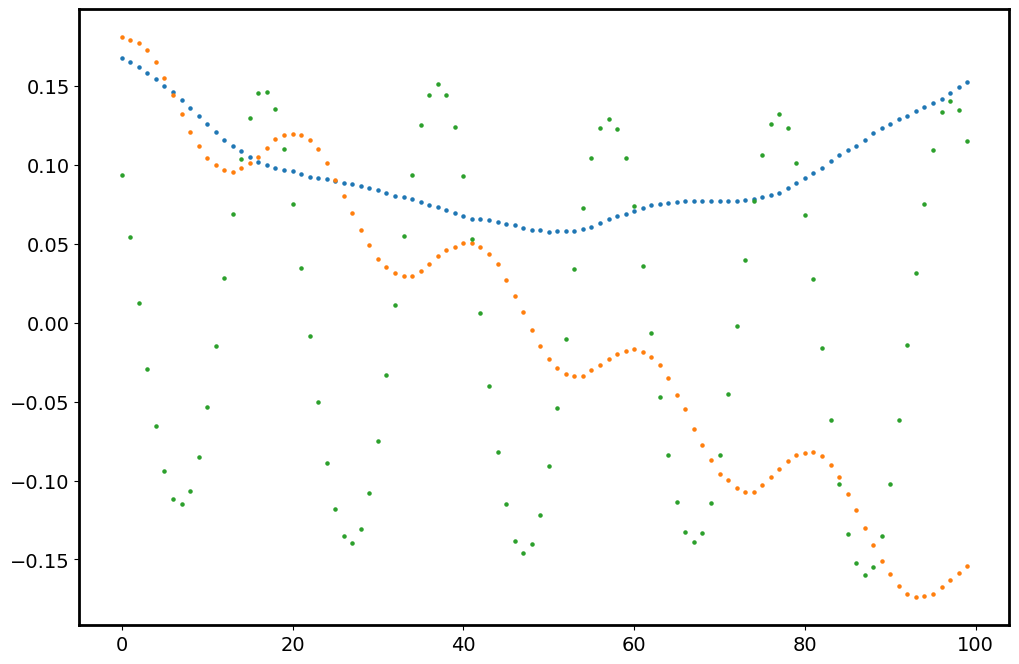

In [6]:
num_eigenvectors_to_plot = min(3, U.shape[1])
for i in range(num_eigenvectors_to_plot):
    plt.scatter(range(len(U[:, i])), U[:, i], s=5)
plt.show()

# 6. Individual Rank-1 Components

From the decomposition, we can isolate each rank-1 portion of the trajectory matrix. Each portion might capture different aspects of the signal, such as the main trend or different frequencies.

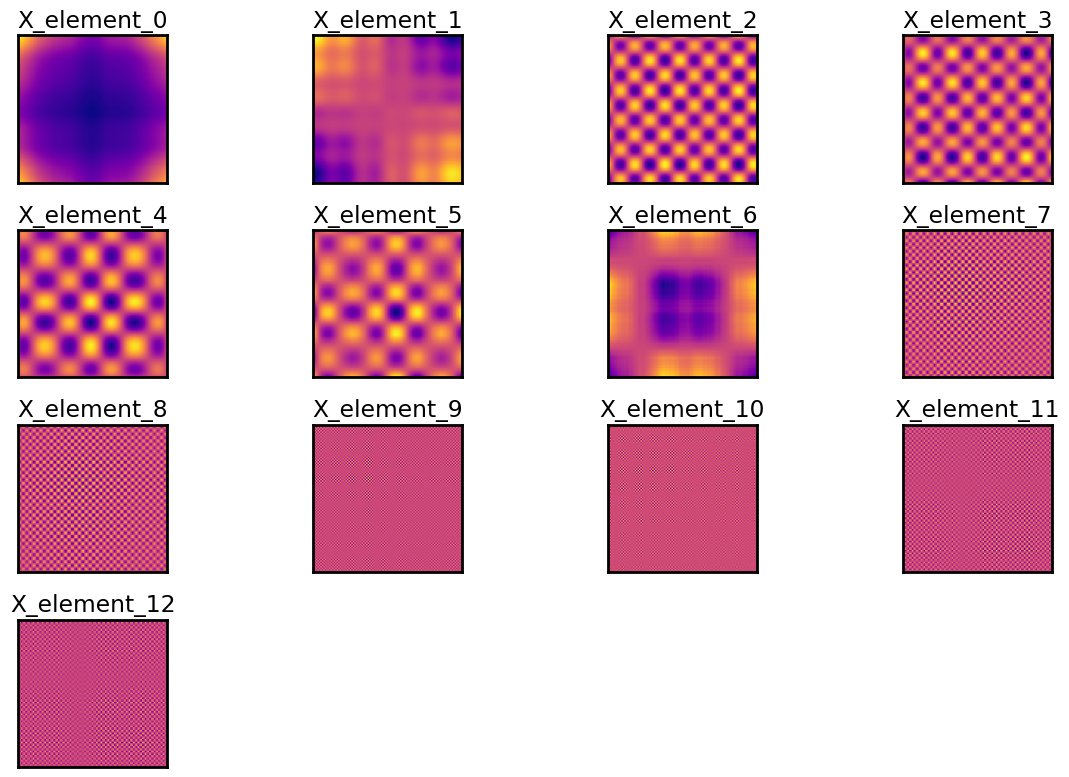

In [7]:
n = min(12, d)
for i in range(n + 1):
    plt.subplot(4, 4, i + 1)
    title = "X_element_" + str(i)
    plot_2d(X_element[i], title)
plt.tight_layout()
plt.show()

# 7. Relative and Cumulative Contributions

Every piece of the decomposition accounts for a certain amount of the total variation in the data. We can see which ones contribute the most and how they add up overall.

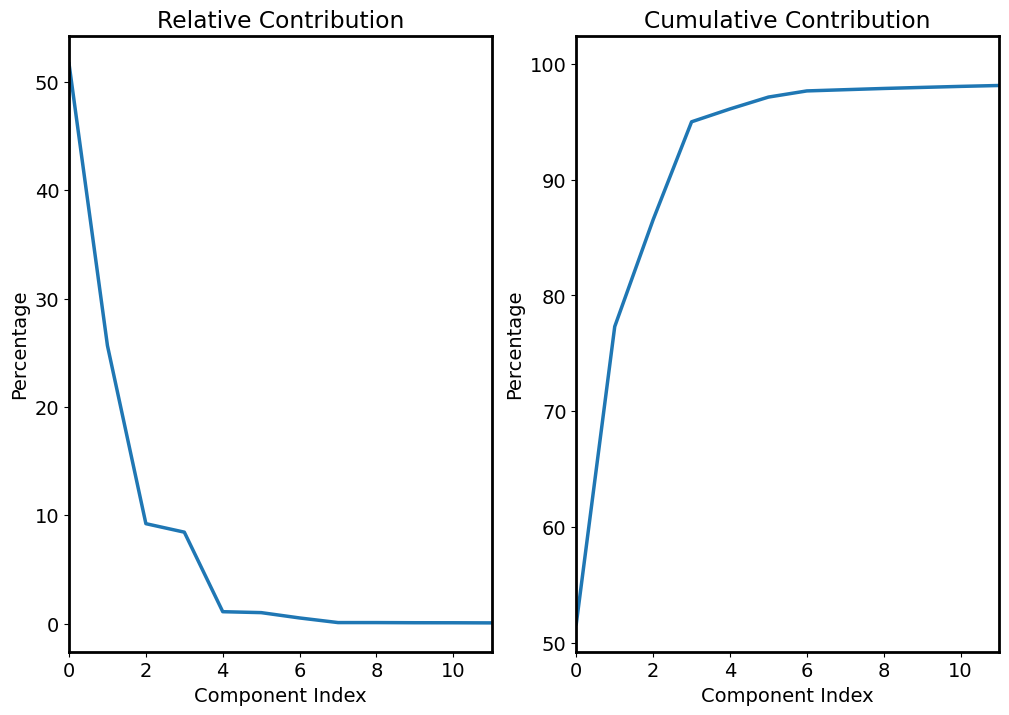

In [8]:
Relative_Con = np.sum(Sigma ** 2)
Cumulative_Con = np.cumsum(Sigma ** 2)

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot((Sigma ** 2 / Relative_Con) * 100, lw=2.5)
ax[0].set_xlim(0, 11)
ax[0].set_title('Relative Contribution')
ax[0].set_xlabel('Component Index')
ax[0].set_ylabel('Percentage')

ax[1].plot(Cumulative_Con / Relative_Con * 100, lw=2.5)
ax[1].set_xlim(0, 11)
ax[1].set_title('Cumulative Contribution')
ax[1].set_xlabel('Component Index')
ax[1].set_ylabel('Percentage')
plt.show()

# 8. Enforcing Hankel Structure

After decomposition, each piece may lose the original sliding-window pattern. We fix that through a process sometimes called "Hankelization," which makes sure the rows and columns align in the same way they do in the trajectory matrix.

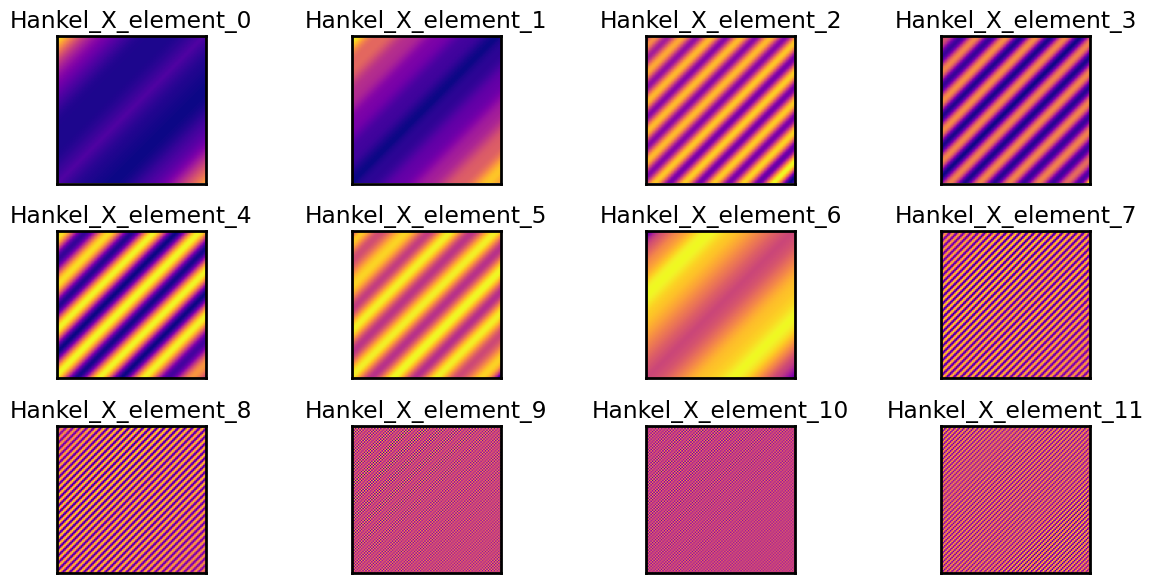

In [9]:
def HankelOp(X):
    Lx, Kx = X.shape
    transpose = False
    if Lx > Kx:
        X = X.T
        Lx, Kx = Kx, Lx
        transpose = True
    HX = np.zeros((Lx, Kx))
    for m in range(Lx):
        for n in range(Kx):
            s = m + n
            if 0 <= s <= Lx - 1:
                for i in range(s + 1):
                    HX[m, n] += X[i, s - i] / (s + 1)
            elif Lx <= s <= Kx - 1:
                for i in range(Lx):
                    HX[m, n] += X[i, s - i] / Lx
            else:
                for i in range(s - Kx + 1, Lx):
                    HX[m, n] += X[i, s - i] / (Kx + Lx - s - 1)
    if transpose:
        return HX.T
    return HX

n = min(12, d)
for i in range(n):
    plt.subplot(4, 4, i + 1)
    title = "Hankel_X_element_" + str(i)
    plot_2d(HankelOp(X_element[i]), title)
plt.tight_layout()
plt.show()

# 9. Converting Hankelized Components to 1D

Once each piece is Hankelized, we can turn it into a one-dimensional time series again by taking appropriate averages along diagonals. This is sometimes called diagonal averaging.

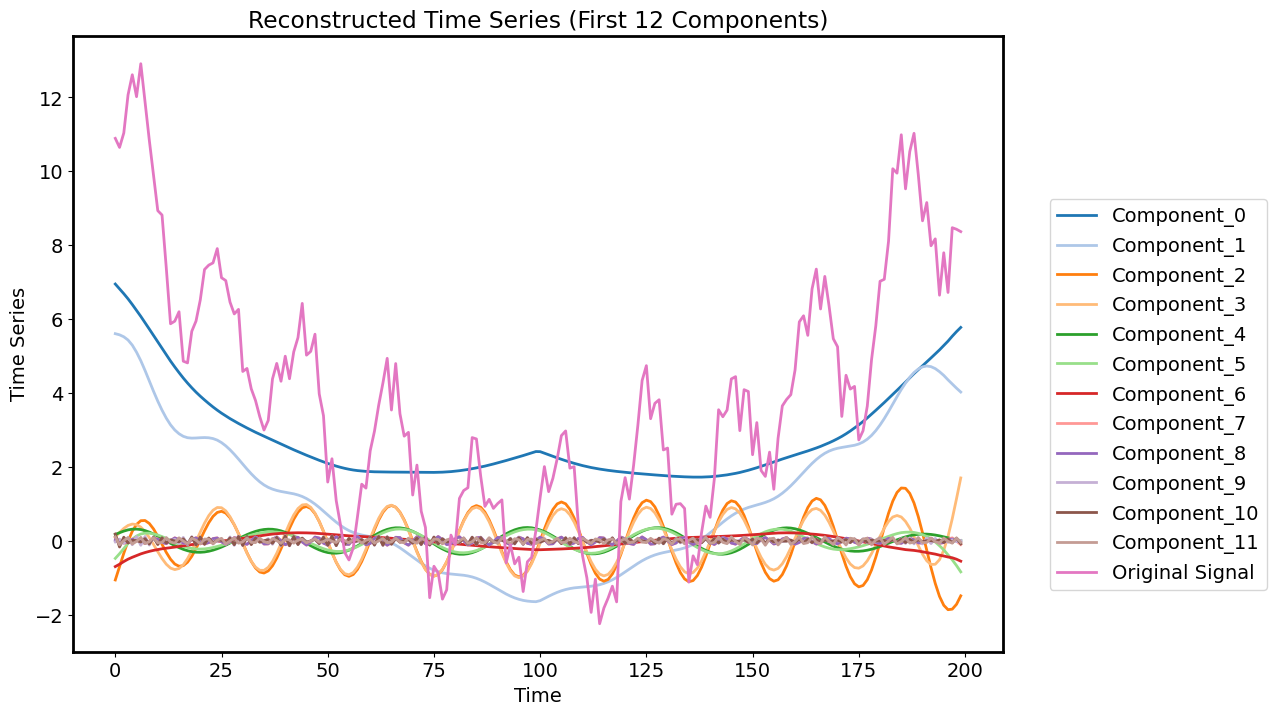

In [10]:
def shortcut(X_i):
    X_reverse = X_i[::-1]
    diags = [X_reverse.diagonal(i).mean() for i in range(-X_i.shape[0] + 1, X_i.shape[1])]
    return diags

n = 12
fig_axis = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig_axis.axes.set_prop_cycle(color_cycle)

for i in range(n):
    time_series = shortcut(X_element[i])
    fig_axis.axes.plot(t, time_series, lw=2)

fig_axis.axes.plot(t, signal, lw=2)
fig_axis.set_xlabel('Time')
fig_axis.set_ylabel('Time Series')
legend = ["Component_" + str(i) for i in range(n)] + ["Original Signal"]
fig_axis.set_title('Reconstructed Time Series (First 12 Components)')
fig_axis.legend(legend, loc=(1.05, 0.1))
plt.show()


# 10. W-Correlation Matrix

To figure out which components might be related (for instance, which ones contribute to the same periodic effect), we calculate a correlation measure across the reconstructed components. This helps decide whether some components should be grouped together.

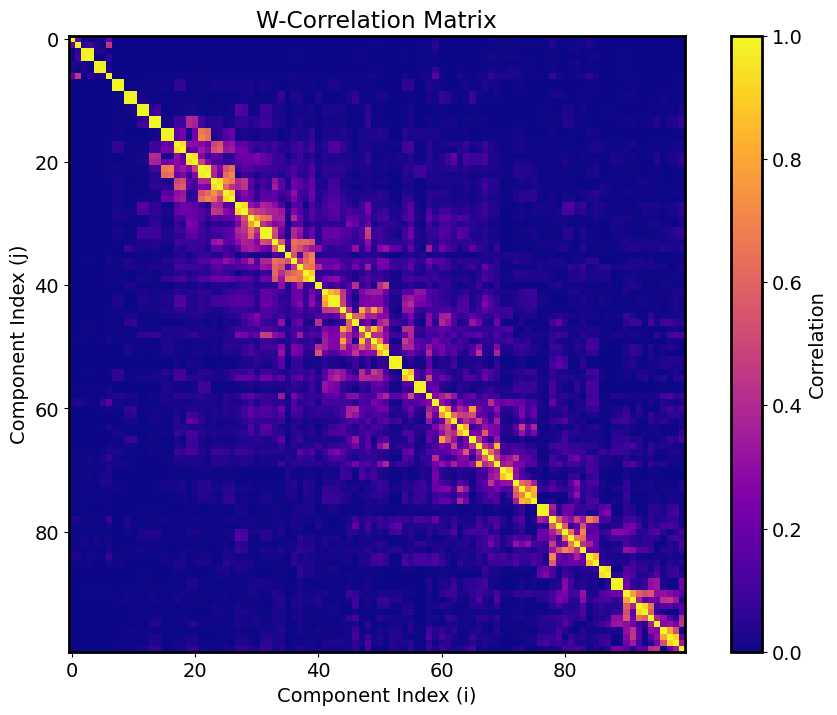

In [11]:
w = np.array(list(np.arange(L) + 1) + [L] * (K - L - 1) + list(np.arange(L) + 1)[::-1])
Signal_i = np.array([shortcut(X_element[i]) for i in range(d)])
Norm_signal = np.array([w.dot(Signal_i[i] ** 2) for i in range(d)]) ** -0.5

W_corr = np.identity(d)
for i in range(d):
    for j in range(i + 1, d):
        W_corr[i, j] = abs(w.dot(Signal_i[i] * Signal_i[j]) * Norm_signal[i] * Norm_signal[j])
        W_corr[j, i] = W_corr[i, j]

ax = plt.imshow(W_corr)
plt.xlabel('Component Index (i)')
plt.ylabel('Component Index (j)')
plt.colorbar(ax.colorbar, fraction=0.045).set_label("Correlation")
plt.clim(0, 1)
plt.title("W-Correlation Matrix")
plt.show()

# 11. Annotating W-Correlation (Selected Components)

Here, we highlight a smaller set of components, drawing the correlation values directly on the plot for clarity.

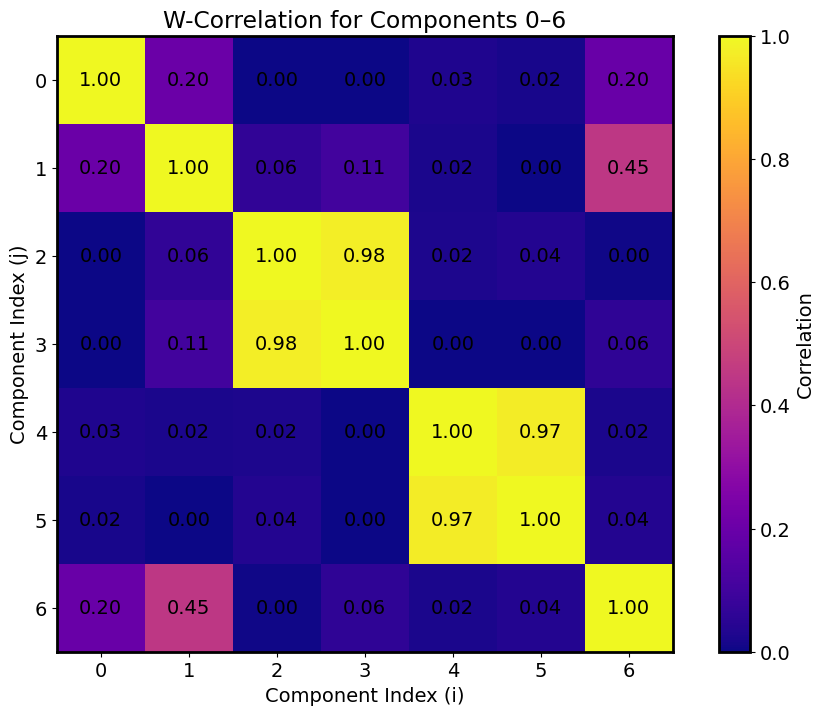

In [12]:
ax = plt.imshow(W_corr)
plt.xlabel('Component Index (i)')
plt.ylabel('Component Index (j)')
plt.colorbar(ax.colorbar, fraction=0.045).set_label("Correlation")
plt.xlim(-0.5, 6.5)
plt.ylim(6.5, -0.5)
plt.clim(0, 1)
plt.title("W-Correlation for Components 0–6")

for i in range(W_corr.shape[0] - 93):
    for j in range(W_corr.shape[1] - 93):
        plt.text(j, i, f'{W_corr[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

# 12. Grouping and Final Reconstruction

We combine certain components that are closely correlated to form larger, more meaningful parts of the original time series. For instance, several components might together represent a trend, another set might capture a periodic pattern, and so on.

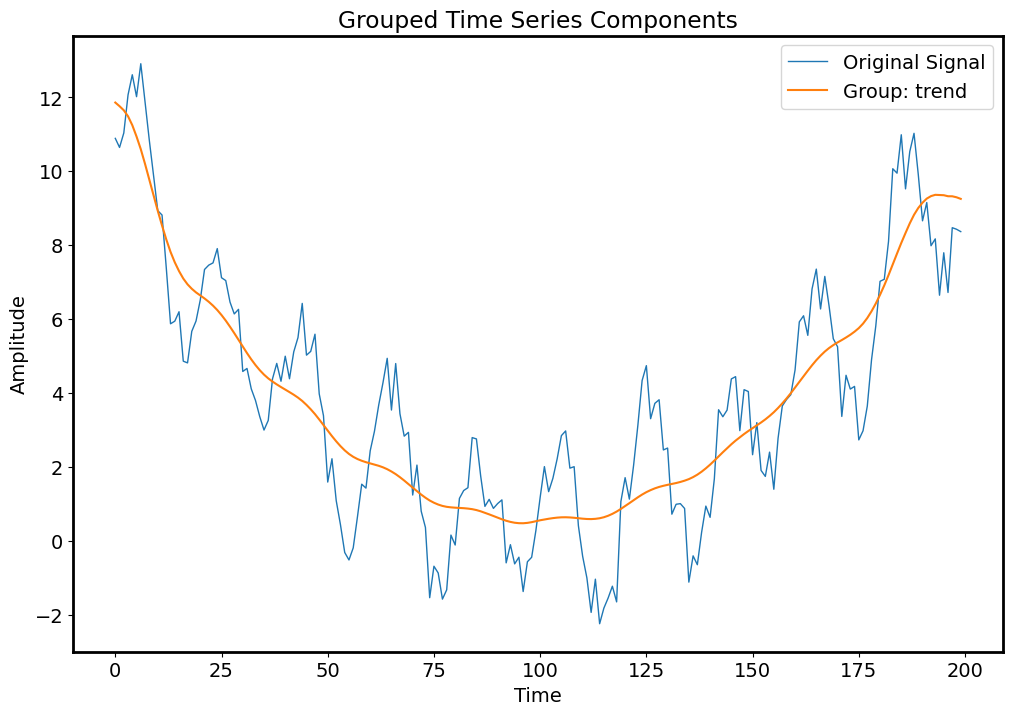

In [13]:
F_trend = shortcut(X_element[[0, 1, 6]].sum(axis=0))

plt.plot(t, signal, lw=1)
plt.plot(t, F_trend)
plt.xlabel("Time")
plt.ylabel("Amplitude")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["Original Signal"] + ["Group: " + g for g in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

# Conclusion

1. We generated a sample time series with multiple components and random noise.  
2. By embedding it into a matrix (the trajectory matrix) and performing a linear algebra decomposition, we isolated rank-1 structures that capture different behaviors.  
3. We enforced the original sliding-window pattern through Hankelization, then converted each component back into a single time series.  
4. Using a correlation measure, we identified which components were likely to represent similar phenomena (e.g., portions of a periodic signal or the overall trend).  
5. Ultimately, we showed how to group these components to reconstruct and analyze the main features of the signal.